# Exercise 2

## Physics 7810
## Due March 16, 2020

## E2.1 - Neighbor lists and cell lists

In this exercise you will implement the *neighbor list* and *cell list* methods for speeding up force/energy calculations in an MD simulation of the two-dimensional (2D) Weeks-Chandler-Andersen (WCA) model with periodic boundary conditions, and will compare the performance of these algorithms with an all-pairs ($O(N^2)$) neighbor search.

Recall that the WCA potential is just the Lennard-Jones potential truncated at the minimum ($r_c = 2^{1/6} \sigma$) and shifted so that the potential is continuous at the cutoff distance. In the WCA model, no long-range corrections to the potential energy or pressure (or other thermodynamic properties) are included.

(1) Write an MD simulation program for the 2D WCA model in a square box with periodic boundary conditions, using the velocity Verlet algorithm, and using an all-pairs search to compute pair interactions. Verify that the program works correctly, with stable dynamics (e.g., good energy conservation). Compare the average potential energy per particle and pressure measured in your simulation with the data in the file `WCA_thermodynamics_T_0.6.pdf` (from my PhD thesis!) in the Modules/Exercises folder in Canvas, which was obtained at a reduced temperature of $T^\ast = 0.6$. Try to reproduce the data on the low-density side of the melting transition ($\rho^\ast < 0.85$). To do this it's helpful to have a way to adjust the temperature of the system (e.g., a *thermostat*). I'd recommend using one of the simplest methods, involving periodic resampling of particle velocities (the *Andersen thermostat*), which is described in Section 3.8.1 in Allen & Tildesley.

(2) Implement the Verlet neighbor list method, with the neighbor list skin $\delta = r_l - r_c$ as an additional parameter that can be varied to optimize the performance of the algorithm. Note that the neighbor list cutoff $r_l$ cannot exceed half the linear dimension of the simulation box (i.e., you should make sure that $r_l \leq L/2$). The neighbor list for each particle can be implemented either as a simple array or as a linked list.

* Verify that using neighbor lists gives identical results to the all-pairs neighbor search, given the same initial conditions, at least for several hundred timesteps. If you see a significant discrepancy, this probably means that there's a mistake in your neighbor list implementation. Use the method discussed in class and in Allen & Tildesley (Section 5.3.1) to determine when to update the neighbor list.

* Measure the speedup of the neighbor list method relative to the all pairs method for various values of $\delta$ and $N$ (the number of particles). Hint: take a look at the `time` and `timeit` Python modules.

(3) Implement the cell search method, and repeat the steps outlined above for the neighbor list method. I'd recommend implementing the cell method using double-connected linked lists, as discussed in class and in Allen & Tildesley (Section 5.3.2). To acheive the best performance, you'll need to define `head` and `tail` arrays that contain the labels of the first and last particles in the linked list for each cell, `prev` and `next` arrays that contain the labels of the previous and next particles in the linked list that a given particle belongs to, and a `cell` array that specifies which cell a given particle is assigned to. Some care needs to be taken in handling periodic boundary conditions when using cell lists to calculate energies and forces.

### Solution

#### Problem 1: Acceleration of the code

First, we import the package for MD simulations.

In [1]:
import time
import sys
sys.path.insert(1, '../')  # so the system can locate the library folder
from CompPhysLib.Molecular_Simulations import *

In [2]:
param = Initialization('Exercise_02.yml')
MD = MolecularDynamics(param)

In [3]:
%%prun -s cumulative -q -l 15 -T prun0
t1 = time.time()
MD.search_method = 'all-pairs'
MD.verlet_integration(MD.velocities, MD.coords)
t2 = time.time()
print('Elapsed time: %s' % (t2-t1))

Elapsed time: 28.557636260986328
 
*** Profile printout saved to text file 'prun0'. 


10.805191097472726


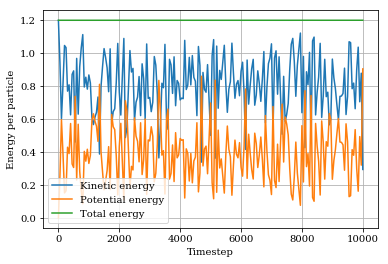

In [12]:
TA = TrajAnalysis(MD, 'Exercise_02_traj.yml')
print(TA.E_total[-1])
TA.plot_MD_energy()

In [13]:
print(open('prun0', 'r').read())

         19205126 function calls (19199096 primitive calls) in 25.063 seconds

   Ordered by: cumulative time
   List reduced from 128 to 15 due to restriction <15>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000   25.063   25.063 {built-in method builtins.exec}
        1    0.000    0.000   25.063   25.063 <string>:2(<module>)
        1    0.201    0.201   25.062   25.062 Molecular_Simulations.py:719(verlet_integration)
    20000    2.030    0.000   17.133    0.001 Molecular_Simulations.py:318(total_force)
  1080036    4.945    0.000   15.344    0.000 Molecular_Simulations.py:252(calc_dist)
   720000    3.165    0.000   14.660    0.000 Molecular_Simulations.py:298(LJ_force_ij)
    10001    0.079    0.000    7.485    0.001 Molecular_Simulations.py:843(output_data)
    10001    0.635    0.000    7.322    0.001 Molecular_Simulations.py:484(total_potential)
  1090037    3.893    0.000    7.205    0.000 linalg.py:2293(norm)
   360036    

In [14]:
%%prun -s cumulative -q -l 15 -T prun1
t1 = time.time()
MD.search_method = 'verlet'
MD.verlet_integration(MD.velocities, MD.coords)
t2 = time.time()
print('Elapsed time: %s' % (t2-t1))

Elapsed time: 21.744179487228394
 
*** Profile printout saved to text file 'prun1'. 


10.805191097472726


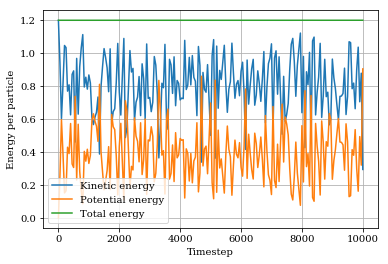

In [15]:
TA = TrajAnalysis(MD, 'Exercise_02_traj.yml')
print(TA.E_total[-1])
TA.plot_MD_energy()

In [16]:
print(open('prun1', 'r').read())

         14660568 function calls (14654538 primitive calls) in 21.744 seconds

   Ordered by: cumulative time
   List reduced from 134 to 15 due to restriction <15>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000   21.744   21.744 {built-in method builtins.exec}
        1    0.000    0.000   21.744   21.744 <string>:2(<module>)
        1    0.304    0.304   21.744   21.744 Molecular_Simulations.py:719(verlet_integration)
    20000    1.678    0.000   14.216    0.001 Molecular_Simulations.py:318(total_force)
   487846    3.192    0.000   12.040    0.000 Molecular_Simulations.py:298(LJ_force_ij)
   735642    3.778    0.000   11.613    0.000 Molecular_Simulations.py:252(calc_dist)
   835643    3.296    0.000    6.108    0.000 linalg.py:2293(norm)
    10001    0.092    0.000    6.096    0.001 Molecular_Simulations.py:843(output_data)
    10001    0.470    0.000    5.912    0.001 Molecular_Simulations.py:484(total_potential)
   243944    

0.17755071962448107

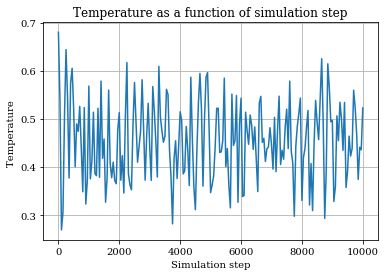

In [60]:
TA = TrajAnalysis(MD, 'Exercise_02_traj.yml')
TA.plot_2d(TA.temp, 'Temperature')
TA.calculate_RMSF(TA.temp)

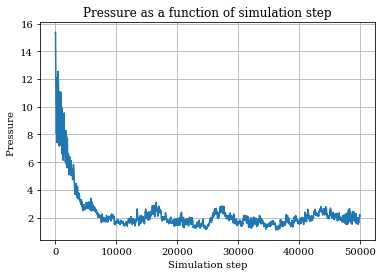

In [13]:
TA.plot_2d(TA.pressure, 'Pressure')

In [17]:
len(TA.pressure)

5001

In [19]:
np.mean(TA.pressure[4000:])

2.071241680753028

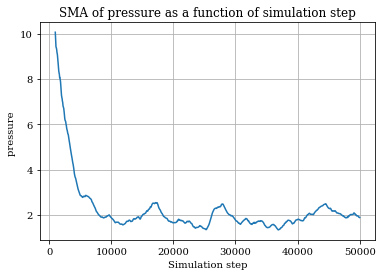

In [14]:
SMA = TA.plot_SMA(100, TA.pressure, 'pressure')

In [18]:
MD.coords

array([[-1.11803399, -1.11803399],
       [-1.11803399,  0.        ],
       [-1.11803399,  1.11803399],
       [ 0.        , -1.11803399],
       [ 0.        ,  0.        ],
       [ 0.        ,  1.11803399],
       [ 1.11803399, -1.11803399],
       [ 1.11803399,  0.        ],
       [ 1.11803399,  1.11803399]])

#### Problem 2: Application of Andersen thermostat the the reproduction of the `WCA_thermodynamics_T_0.6`

In [13]:
import time
import sys
sys.path.insert(1, '../')  # so the system can locate the library folder
from CompPhysLib.Molecular_Simulations import *

In [14]:
param = Initialization('Exercise_02.yml')
MD = MolecularDynamics(param)

In [15]:
%%prun -s cumulative -q -l 15 -T prun1
t1 = time.time()
MD.search_method = 'cell'
MD.verlet_integration(MD.velocities, MD.coords)
t2 = time.time()
print('Elapsed time: %s' % (t2-t1))

Elapsed time: 44.5528621673584
 
*** Profile printout saved to text file 'prun1'. 


2015.7137759019759

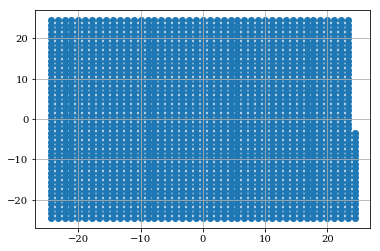

In [16]:
TA = TrajAnalysis(MD, 'Exercise_02_traj.yml')
#TA.plot_xy_traj()
plt.scatter(TA.x, TA.y)
plt.grid()
TA.E_total[-1]

In [ ]:
%%prun -s cumulative -q -l 15 -T prun1
t1 = time.time()
MD.search_method = 'verlet'
MD.verlet_integration(MD.velocities, MD.coords)
t2 = time.time()
print('Elapsed time: %s' % (t2-t1))

In [ ]:
TA = TrajAnalysis(MD, 'Exercise_02_traj.yml')
#TA.plot_xy_traj()
plt.scatter(TA.x, TA.y)
plt.grid()
TA.E_total[-1]

In [1]:
import time
import sys
sys.path.insert(1, '../')  # so the system can locate the library folder
from CompPhysLib.Molecular_Simulations import *

In [2]:
print(open('prun0', 'r').read())

         48048 function calls (47625 primitive calls) in 0.084 seconds

   Ordered by: cumulative time
   List reduced from 245 to 10 due to restriction <10>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    0.084    0.084 {built-in method builtins.exec}
        1    0.000    0.000    0.084    0.084 <string>:2(<module>)
        1    0.000    0.000    0.053    0.053 Molecular_Simulations.py:693(verlet_integration)
        1    0.000    0.000    0.040    0.040 Molecular_Simulations.py:786(output_data)
        1    0.011    0.011    0.040    0.040 Molecular_Simulations.py:390(virial)
        1    0.000    0.000    0.031    0.031 Molecular_Simulations.py:42(__init__)
     1560    0.009    0.000    0.027    0.000 Molecular_Simulations.py:244(calc_dist)
      780    0.003    0.000    0.022    0.000 Molecular_Simulations.py:290(LJ_force_ij)
        1    0.000    0.000    0.016    0.016 __init__.py:65(load)
        1    0.000    0.000    0.

#### Questinos to ask
- The mixing of Newtonian dynamics with stochastic collisions turns the Molecular Dynamics simulation into a Markov process. blablabla
- Draw from maxwell-Boltzmann: not rigorous enough?

In [5]:
A = MD.coords
B = MD.coords + 1

In [25]:
A

array([[-1.24404061,  1.08650181],
       [ 0.85392235, -0.37264796],
       [ 1.05170761,  0.18589252],
       ...,
       [-0.4253722 ,  0.46688536],
       [ 1.19515935,  1.02695679],
       [-0.76023485, -1.27546294]])

In [19]:
a = [C[i][0] ** 2 + C[i][1] ** 2 for i in range(len(C))]

In [28]:
t1 = time.time()
for i in range(10000):
    a = [norm(A[i]-B[i]) for i in range(len(C))]
t2 = time.time()
t2 - t1

33.216803312301636

In [30]:
t1 = time.time()
C = B - A
for i in range(10000):
    a = [norm(C[i]) for i in range(len(C))]
t2 = time.time()
t2 - t1

28.496031999588013

In [31]:
a

[1.4142135623730951,
 1.4142135623730951,
 1.4142135623730951,
 1.4142135623730951,
 1.4142135623730951,
 1.4142135623730951,
 1.4142135623730951,
 1.4142135623730951,
 1.4142135623730951,
 1.4142135623730951,
 1.4142135623730951,
 1.4142135623730951,
 1.4142135623730951,
 1.4142135623730951,
 1.414213562373095,
 1.4142135623730951,
 1.4142135623730951,
 1.4142135623730951,
 1.4142135623730951,
 1.414213562373095,
 1.4142135623730951,
 1.4142135623730951,
 1.4142135623730951,
 1.4142135623730951,
 1.4142135623730951,
 1.414213562373095,
 1.414213562373095,
 1.414213562373095,
 1.4142135623730951,
 1.4142135623730951,
 1.414213562373095,
 1.414213562373095,
 1.414213562373095,
 1.414213562373095,
 1.414213562373095,
 1.4142135623730951,
 1.4142135623730951,
 1.4142135623730951,
 1.4142135623730951,
 1.4142135623730951,
 1.4142135623730951,
 1.4142135623730951,
 1.414213562373095,
 1.4142135623730951,
 1.4142135623730951,
 1.4142135623730951,
 1.4142135623730951,
 1.414213562373095,
 1.4